## Implementing Guided Backpropagation on last convolution layer of Discriminator model to visualize learned convolutional features

In [2]:
# Import and utils
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)  
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from glob import glob

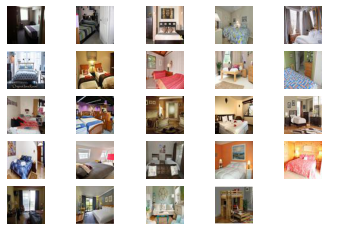

In [5]:
# Display original images
for i in range (0,25):
    x = np.array(glob('test_imgs/*.jpg'))
    image =  plt.imread(x[i])
    plt.imshow(image)
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.axis("off")
plt.savefig('./results/Guided_backprop/im1.png')
plt.show()

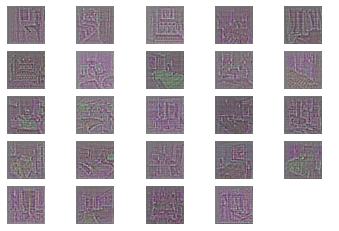

In [7]:
# Guided Backpropagation process
for i in range (0,25):
    x = np.array(glob('test_imgs/*.jpg'))
    image =  plt.imread(x[i])
    img = image
    
    #Load the discriminator model trained on the LSUN dataset upto last convolution layer - conv2d_11 
    model = tf.keras.models.load_model("./trained_models/DCGAN_lsun_nobn/discriminator")
    LAYER_NAME = 'conv2d_11'
    
    # Preprocess image to [1-,1] and shape (None,64,64,3)
    image =  image.astype('float32')
    image = (image-127.5)/127.5
    image=image.reshape(-1,64,64,3)

    gb_model = tf.keras.models.Model(
        inputs = [model.inputs],    
        outputs = [model.get_layer(LAYER_NAME).output]
    )
    layer_dict = [layer for layer in gb_model.layers[1:] if hasattr(layer,'activation')]

    @tf.custom_gradient
    def guidedRelu(x):
        def grad(dy):
            return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
        return tf.nn.relu(x), grad

    for layer in layer_dict:
        if layer.activation == tf.keras.activations.relu:
            layer.activation = guidedRelu

    with tf.GradientTape() as tape:
        inputs = tf.cast(image, tf.float32)
        tape.watch(inputs)
        outputs = gb_model(inputs)[0]
    grads = tape.gradient(outputs,inputs)[0]

    guided_back_prop = grads
    gb_viz = np.dstack((
                guided_back_prop[:, :, 0],
                guided_back_prop[:, :, 1],
                guided_back_prop[:, :, 2],
            ))       
    gb_viz -= np.min(gb_viz)
    gb_viz /= gb_viz.max()

    imgplot = plt.imshow(gb_viz)
    
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.axis("off")
plt.savefig('./results/Guided_backprop/im2.png')
plt.show()




References: 
https://towardsdatascience.com/how-to-visually-explain-any-cnn-based-models-80e0975ce57